# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error,mean_squared_error
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold
!pip install fast_ml
from fast_ml.model_development import train_valid_test_split
from sklearn.model_selection import cross_validate
from catboost import cv

     |████████████████████████████████| 42 kB 684 kB/s eta 0:00:011


In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.columns = df.columns.str.lower() # приведем название столбцов к строчному виду

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  notrepaired        283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
# проверим наличие пропусков
print(df['price'].isna().sum())
print(df['vehicletype'].isna().sum())
print(df['registrationyear'].isna().sum())
print(df['gearbox'].isna().sum())
print(df['power'].isna().sum())
print(df['model'].isna().sum())
print(df['kilometer'].isna().sum())
print(df['registrationmonth'].isna().sum())
print(df['fueltype'].isna().sum())
print(df['brand'].isna().sum())
print(df['notrepaired'].isna().sum())
print(df['datecreated'].isna().sum())
print(df['numberofpictures'].isna().sum())
print(df['postalcode'].isna().sum())
print(df['lastseen'].isna().sum())

0
37490
0
19833
0
19705
0
0
32895
0
71154
0
0
0
0


In [7]:
# проверил наличие дубликатов, их не много, можно удалить их
df.duplicated().sum()

4

In [8]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [9]:
# посмотрим уникальные значения столбцов где есть пропуски
print(df['vehicletype'].unique())
print(df['gearbox'].unique())
print(df['model'].unique())
print(df['fueltype'].unique())
print(df['notrepaired'].unique())
print(df['numberofpictures'].unique()) # проверил, убедился что в данном столбце нет значеий, его можно удалить, он не информативен

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3

In [10]:
# Удалим не нужные нам столбцы
df = df.drop(['numberofpictures', 'datecrawled', 'datecreated', 'lastseen', 'postalcode'], axis=1)


In [11]:
display(df.head())

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [12]:
# Модель автомобилей основополагающий признак, без них не определить цену, удалим пропущенные значения.
df.dropna(subset=['model'], inplace=True)

In [13]:
# заменим пропущенные значения только в столбцах gearbox,fueltype,vehicletype и notrepaired, 
#в остальных столбцах значения не возможно заменить на что то конкретное.
df['gearbox'] = df['gearbox'].fillna('manual') # думаю не указали вид коробки потому что она механическая
df['notrepaired'] = df['notrepaired'].fillna('no') # думаю не указали повреждения потому что их нет
df['fueltype']=df['fueltype'].fillna('other') # заполним значения как other
df['vehicletype']=df['vehicletype'].fillna('other') # заполним значения как other

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334660 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              334660 non-null  int64 
 1   vehicletype        334660 non-null  object
 2   registrationyear   334660 non-null  int64 
 3   gearbox            334660 non-null  object
 4   power              334660 non-null  int64 
 5   model              334660 non-null  object
 6   kilometer          334660 non-null  int64 
 7   registrationmonth  334660 non-null  int64 
 8   fueltype           334660 non-null  object
 9   brand              334660 non-null  object
 10  notrepaired        334660 non-null  object
dtypes: int64(5), object(6)
memory usage: 30.6+ MB


In [15]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth
count,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076,5.806075
std,4531.457109,69.377633,185.157391,37205.638630,3.689157
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Видим что есть аномалии столбцах:

В стобце 'price' есть автомобили с ценой о;

В стобце "registrationyear" есть автомобили с датой регистрацией 1000г и 9999г;

В столбце "power" есть автомобилис мощностью 0 и до 20000 л.с.;

В столбце "registrationmonth" есть значение 0, заменим их единицей.

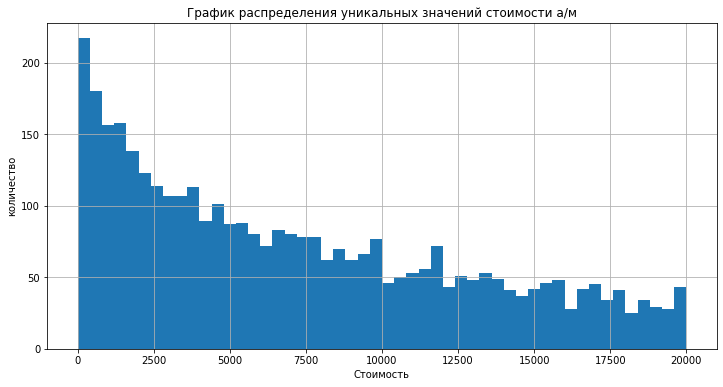

In [16]:
pd.Series(list(df.price.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений стоимости а/м')
plt.ylabel('количество')
plt.xlabel('Стоимость')
plt.show()

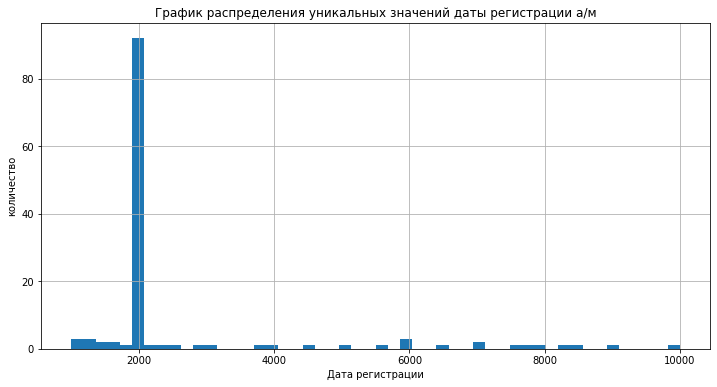

In [17]:
pd.Series(list(df.registrationyear.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений даты регистрации а/м')
plt.ylabel('количество')
plt.xlabel('Дата регистрации')
plt.show()

Text(0.5, 0, 'Мощность, л.с.')

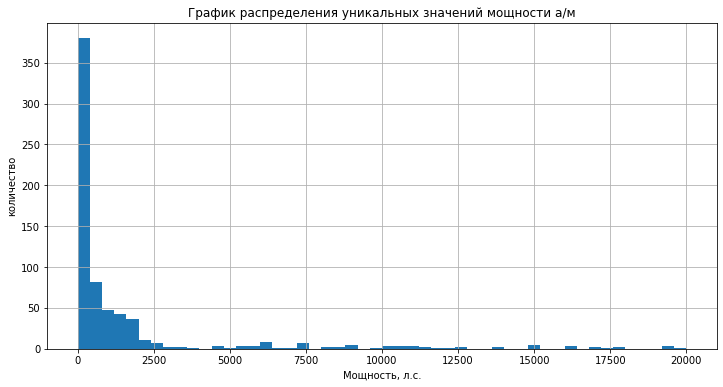

In [18]:
pd.Series(list(df.power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
#plt.show()

In [19]:
# Удалим данные с ценой ниже 100 долларов
df=df.query('price >= 100')
# Удалим год регистрации до 1930 и после 2016гг
df=df.query('registrationyear >= 1930 & registrationyear <= 2016')
# Удалим автомобили с мощностью ниже 30 л.с. и выше 2500л.с.
df=df.query('power >= 30 & power < 2500')

In [20]:
df.loc[df['registrationmonth'] == 0,'registrationmonth'] =1

In [21]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth
count,283934.000000,283934.000000,283934.000000,283934.000000,283934.000000
mean,4917.169307,2002.972148,121.787824,128394.891066,6.091394
std,4618.711867,6.274426,63.485715,36485.442022,3.478494
min,100.000000,1931.000000,30.000000,5000.000000,1.000000
25%,1399.000000,1999.000000,77.000000,125000.000000,3.000000
50%,3250.000000,2003.000000,113.000000,150000.000000,6.000000
75%,7000.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2016.000000,2461.000000,150000.000000,12.000000


In [22]:
display(df.head())

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


In [23]:
print(df.isna().sum())

price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
dtype: int64


In [24]:
# Сбросим индексы после всех действий
df=df.reset_index(drop=True)

## Обучение моделей

In [25]:
# Разделим данные на целевой признак и основные
features = df.drop(['price'], axis=1)  # извлекаем признаки 
target = df['price'] # извлекаем целевой признак

In [26]:
# Разделим на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345) # разобьем на обучающую и тестовые выборки


С помощью метода OrdinalEncoder применим кодирование текстовых данных в категориальные цифровые значения 

In [27]:
# Выберем нужные столбцы
column=['vehicletype', 'gearbox','model',
       'fueltype', 'brand', 'notrepaired']

In [28]:
encoder = OrdinalEncoder()
encoder.fit(features_train[column])
features_ord=features.copy()
features_ord[column]= pd.DataFrame(encoder.transform(features[column]), columns = features[column].columns)

In [29]:
# Сбросим индексы после всех действий
features_ord=features_ord.reset_index(drop=True)

In [30]:
features_ord.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
0,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,0.0
1,5.0,2001,1.0,75,116.0,150000,6,6.0,37.0,0.0
2,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0
3,4.0,1995,1.0,102,11.0,150000,10,6.0,2.0,1.0
4,1.0,2004,1.0,109,8.0,150000,8,6.0,25.0,0.0


In [31]:
features_train, features_test, target_train, target_test = train_test_split(
    features_ord, target, test_size=0.25, random_state=12345) # разобьем на обучающую и тестовые выборки

In [32]:
features_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
281701,5.0,2004,1.0,136,8.0,150000,4,6.0,25.0,0.0
216492,5.0,2002,1.0,116,80.0,150000,5,6.0,21.0,0.0
249057,4.0,2010,0.0,160,122.0,100000,9,2.0,24.0,0.0
207872,0.0,2012,1.0,84,223.0,150000,3,2.0,37.0,0.0
82630,4.0,2002,1.0,116,59.0,150000,11,2.0,20.0,0.0


С помощью метода StandardScaler применим масштабирование к нашим данным

In [33]:
numeric=['registrationyear','power','kilometer']
scaler=StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric]=scaler.transform(features_train[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_test.shape)

features_train.head()

(212950, 10)
(70984, 10)


,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
281701,5.0,0.164059,1.0,0.227690,8.0,0.592833,4,6.0,25.0,0.0
216492,5.0,-0.154072,1.0,-0.090278,80.0,0.592833,5,6.0,21.0,0.0
249057,4.0,1.118454,0.0,0.609251,122.0,-0.776717,9,2.0,24.0,0.0
207872,0.0,1.436586,1.0,-0.599026,223.0,0.592833,3,2.0,37.0,0.0
82630,4.0,-0.154072,1.0,-0.090278,59.0,0.592833,11,2.0,20.0,0.0


In [34]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

In [35]:
features_lr=pd.get_dummies(df['vehicletype'],drop_first=True)

In [36]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(
    features_lr, target, test_size=0.25, random_state=12345) # разобьем на обучающую и тестовые выборки

In [37]:
# Обучим на LinearRegression
%time
start = time.time()
model_lr = LinearRegression()
model_lr.fit(features_train_lr, target_train_lr)
end = time.time()
t_lr=round(end-start,2)

RMSE_lr = cross_val_score(model_lr, features_train_lr, target_train_lr,scoring='neg_root_mean_squared_error', cv=5).mean()
print(cross_val_score(model_lr, features_train_lr, target_train_lr,scoring='neg_root_mean_squared_error', cv=5).mean())
print(RMSE_lr)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.05 µs
-4360.899473041628
-4360.899473041628


In [38]:
%time
start = time.time()
model_lr.fit(features_train_lr, target_train_lr)
end = time.time()
t_lr_pp=round(end-start,2)

CPU times: user 15 µs, sys: 5 µs, total: 20 µs
Wall time: 5.96 µs


In [39]:
%time
start = time.time()
pred_lr=model_lr.predict(features_train_lr)
end = time.time()
t_lr_p=round(end-start,2)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 4.29 µs


In [41]:
# Обучим на RandomForestRegressor
%time
start = time.time()
model_forest=RandomForestRegressor(random_state=12345, criterion='mse', n_estimators=100)
model_forest.fit(features_train, target_train)
prediction_forest=model_forest.predict(features_train)
end = time.time()
t_rf=round(end-start,2)

param_grid = {'n_estimators': range (10, 51, 10),
              'max_depth': range (1,5)}

scorer = make_scorer(rmse, greater_is_better=False)

clf = RandomForestRegressor()

grid = GridSearchCV(clf, param_grid, scoring=scorer, cv=5)
grid.fit(features_train, target_train)
print(grid.best_score_)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 4.29 µs
-2545.4139999999998


In [42]:
RMSE_rf = grid.best_score_
print(RMSE_rf)

-2545.4139999999998


In [43]:
%time
start = time.time()
grid.fit(features_train, target_train)
end = time.time()
t_rf_pp=round(end-start,2)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [44]:
%time
start = time.time()
pred_rf=grid.predict(features_train)
end = time.time()
t_rf_p=round(end-start,2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [46]:
# Обучим на CatBoostRegressor
%time
start = time.time()
model_cat = CatBoostRegressor(n_estimators=1000, random_state=12345, learning_rate=0.4,verbose=100)
model_cat.fit(features_train, target_train, eval_set=(features_train,target_train))
end = time.time()
t_cat=round(end-start,2)

params_cat = {
    'learning_rate': [0.1,0.4],
    'depth': [4, 10],
    }

grid_cat = GridSearchCV(estimator=model_cat,param_grid = params_cat, scoring='neg_root_mean_squared_error', cv=5)
grid_cat.fit(features_train, target_train)
print(grid_cat.best_score_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
0:	learn: 3506.5656316	test: 3506.5656316	best: 3506.5656316 (0)	total: 95.5ms	remaining: 1m 35s
100:	learn: 1598.4992847	test: 1598.4992847	best: 1598.4992847 (100)	total: 2.93s	remaining: 26.1s
200:	learn: 1521.0216257	test: 1521.0216257	best: 1521.0216257 (200)	total: 5.8s	remaining: 23.1s
300:	learn: 1473.9216149	test: 1473.9216149	best: 1473.9216149 (300)	total: 8.9s	remaining: 20.7s
400:	learn: 1442.2565565	test: 1442.2565565	best: 1442.2565565 (400)	total: 12s	remaining: 17.9s
500:	learn: 1415.4168290	test: 1415.4168290	best: 1415.4168290 (500)	total: 14.8s	remaining: 14.8s
600:	learn: 1393.0894298	test: 1393.0894298	best: 1393.0894298 (600)	total: 17.7s	remaining: 11.8s
700:	learn: 1374.3358473	test: 1374.3358473	best: 1374.3358473 (700)	total: 20.7s	remaining: 8.81s
800:	learn: 1357.8808473	test: 1357.8808473	best: 1357.8808473 (800)	total: 23.6s	remaining: 5.86s
900:	learn: 1343.8245471	test: 1343.8245471	best: 1

In [47]:
RMSE_cat = grid_cat.best_score_
print(RMSE_cat)

-1500.9125731062484


In [48]:
%time
start = time.time()
grid_cat.fit(features_train, target_train)
end = time.time()
t_cat_pp=round(end-start,2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
0:	learn: 4351.8144438	total: 19.2ms	remaining: 19.2s
100:	learn: 1873.1294392	total: 1.71s	remaining: 15.2s
200:	learn: 1762.4097599	total: 3.34s	remaining: 13.3s
300:	learn: 1709.0843138	total: 4.92s	remaining: 11.4s
400:	learn: 1676.4385635	total: 6.59s	remaining: 9.85s
500:	learn: 1651.5660485	total: 8.21s	remaining: 8.18s
600:	learn: 1633.2058951	total: 9.82s	remaining: 6.52s
700:	learn: 1616.9347358	total: 11.5s	remaining: 4.88s
800:	learn: 1604.1100581	total: 13s	remaining: 3.23s
900:	learn: 1593.4760423	total: 14.6s	remaining: 1.6s
999:	learn: 1583.0964430	total: 16.1s	remaining: 0us
0:	learn: 4337.0165284	total: 19ms	remaining: 18.9s
100:	learn: 1871.8131327	total: 1.77s	remaining: 15.8s
200:	learn: 1759.6018370	total: 3.55s	remaining: 14.1s
300:	learn: 1710.0173241	total: 5.23s	remaining: 12.2s
400:	learn: 1676.0771335	total: 6.87s	remaining: 10.3s
500:	learn: 1651.2279605	total: 8.62s	remaining: 8.58s
600:	learn

In [49]:
%time
start = time.time()
predict_cat=grid_cat.predict(features_train)
end = time.time()
t_cat_p=round(end-start,2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [51]:
# Обучим на LGBMRegressor
%time
start = time.time()

model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=12345, learning_rate=0.4,verbose=100, objective='rmse')
model_LGB.fit(features_train, target_train, eval_set=(features_train,target_train), verbose=100)
end = time.time()
t_LGB=round(end-start,2)

params_LGB = {
    'learning_rate': [0.1,0.4],
    'depth': [4, 10],
}

grid_LGB = GridSearchCV(estimator=model_LGB,param_grid = params_LGB, scoring='neg_root_mean_squared_error', cv=5)
grid_LGB.fit(features_train, target_train)
print(grid_LGB.best_score_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.852910
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.180550
[LightGBM] [Debug] init for col-wise cost 0.196203 seconds, init for row-wise cost 0.196043 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.301570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 212950, number of used features: 10
[LightGBM] [Info] Start training from score 4921.243137
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[Ligh

In [52]:
RMSE_LGB = grid_LGB.best_score_

In [53]:
print(RMSE_LGB)

-1505.700939370252


In [54]:
%time
start = time.time()
grid_LGB.fit(features_train, target_train)
end = time.time()
t_LGB_pp=round(end-start,2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.77 µs
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.852876
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.180510
[LightGBM] [Debug] init for col-wise cost 0.002549 seconds, init for row-wise cost 0.093594 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 651
[LightGBM] [Info] Number of data points in the train set: 170360, number of used features: 10
[LightGBM] [Info] Start training from score 4922.391336
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6


In [55]:
%time
start = time.time()
predict_LGB=grid_LGB.predict(features_train)
end = time.time()
t_LGB_p=round(end-start,2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


## Анализ моделей

In [57]:
column=['RMSE модели','Скорость обучения, s','Скорость предсказания, s']

general_tabl = pd.DataFrame(index=['RMSE модели','Скорость обучения, s', 'Скорость предсказания, s'], columns=['RandomForestRegressor','CatBoostRegressor','LightGBM'])
general_tabl['LinearRegression'] = RMSE_lr, t_lr_pp, t_lr_p
general_tabl['RandomForestRegressor'] = RMSE_rf, t_rf_pp, t_rf_p
general_tabl['CatBoostRegressor'] = RMSE_cat, t_cat_pp, t_cat_p
general_tabl['LightGBM'] = RMSE_LGB,t_LGB_pp,t_LGB_p

general_tabl.T.style.highlight_min(color='yellowgreen',subset=column).highlight_null(null_color='lightgrey').highlight_max(color='coral',subset=column)

,RMSE модели,"Скорость обучения, s","Скорость предсказания, s"
RandomForestRegressor,-2545.414000,192.810000,0.230000
CatBoostRegressor,-1500.912573,691.630000,0.930000
LightGBM,-1505.700939,975.780000,19.920000
LinearRegression,-4360.899473,0.120000,0.010000


In [60]:
%time
start = time.time()
predict_cat_t=grid_cat.predict(features_test)
end = time.time()
t_cat_p=round(end-start,2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [61]:
%time
start = time.time()
rmse_cat_t = np.sqrt(mean_squared_error(target_test, predict_cat_t))
print(rmse_LGB)
end = time.time()
t_cat_pr=round(end-start,2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
1338.0143073454387


В условии указано, что решающим факторами при выборе модели являются следующие показатели:

Время обучения

Время предсказания

Качество предсказаний

Мы использовали технологию градиетного бустинга в моделях CatBoostRegressor и LightGBM, и сравнили её с базовыми моделями LinearRegression и RandomForestRegressor

По итогам качества и скорости обучения на тестовых данных - с небольшим отрывом от LightGBM побеждает модель CatBoostRegressor,  уступает по скорости предсказания RandomForestRegressor и LinearRegression, но там большие значения rmse.

Таким образом для компании "Не бит, не крашен" рекомендую модель CatBoostRegressor, т.к. можно немного поступиться со скоростью обучения в пользу достижения скорости работы на новых данных при сохранении приблизительно тех же показателей по качеству предсказания

